In [53]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [54]:
# read data
df = pd.read_csv('../data/player_statistics.csv')

All speeds are in meters per second. Distances are in meter and times are in seconds. The speed zones, however, are noted as kilometers per hour so that the first speed zone is within 0 km/h and 5 km/h, the second between 5 km/h and 10 km/h.

In [55]:
# divide columns into relevant lists
info_vars = ['tournament_id', 'match_id', 'player_id', 'team']
speed_vars = ['top_speed_first', 'top_speed_second', 'avg_speed_with_ball_first', 'avg_speed_with_ball_second']
time_vars = ['onfield_time_first', 'onfield_time_second']
dist_vars = ['distance_first', 'distance_second']
ac_de_vars = ['accelerations_first', 'accelerations_second', 'decelerations_first', 'decelerations_second']
zone_vars = ['time_in_speed_zone_0_5_first','time_in_speed_zone_0_5_second', 'time_in_speed_zone_5_10_first',
             'time_in_speed_zone_5_10_second', 'time_in_speed_zone_10_15_first','time_in_speed_zone_10_15_second',
             'time_in_speed_zone_15_20_first','time_in_speed_zone_15_20_second', 'time_in_speed_zone_20_25_first',
             'time_in_speed_zone_20_25_second', 'time_in_speed_zone_25_plus_first','time_in_speed_zone_25_plus_second']

In [56]:
# create average speed from time and distance variables and add to speed vars
df['avg_speed_first'] = df['distance_first']/df['onfield_time_first']
df['avg_speed_second'] = df['distance_second']/df['onfield_time_second']

speed_vars.append('avg_speed_first')
speed_vars.append('avg_speed_second')

# reorder columns
df = df[info_vars + speed_vars + time_vars + dist_vars + ac_de_vars + zone_vars]
df.head()

,tournament_id,match_id,player_id,team,top_speed_first,top_speed_second,avg_speed_with_ball_first,avg_speed_with_ball_second,avg_speed_first,avg_speed_second,...,time_in_speed_zone_5_10_first,time_in_speed_zone_5_10_second,time_in_speed_zone_10_15_first,time_in_speed_zone_10_15_second,time_in_speed_zone_15_20_first,time_in_speed_zone_15_20_second,time_in_speed_zone_20_25_first,time_in_speed_zone_20_25_second,time_in_speed_zone_25_plus_first,time_in_speed_zone_25_plus_second
0,57,1257,7314,Home,5.49,6.91,1.52,2.58,1.589586,2.097446,...,161.62,364.66,50.58,185.58,10.84,85.66,0.68,11.90,0.16,0.84
1,57,1257,7315,Home,6.20,6.31,1.68,2.99,2.031862,1.991236,...,438.26,322.80,186.48,130.28,55.78,43.70,16.36,7.76,8.00,3.86
2,57,1257,7316,Home,4.97,6.27,2.33,1.64,1.574095,1.582465,...,405.24,423.40,132.60,130.42,14.86,23.36,4.00,3.74,0.96,0.30
3,57,1257,7317,Home,5.90,5.49,2.88,1.88,2.097232,2.229869,...,221.64,235.12,143.34,133.04,66.50,41.64,12.10,3.12,3.64,0.88
4,57,1257,7318,Home,5.56,5.92,2.21,2.32,1.381493,1.842439,...,211.28,214.18,58.00,95.06,7.98,16.06,2.12,2.56,1.06,2.34


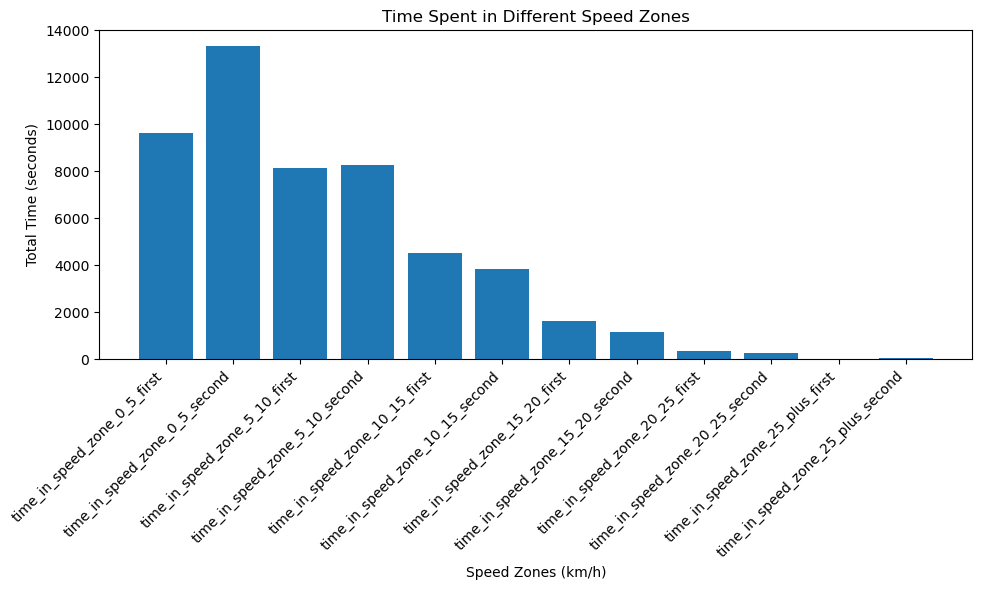

In [64]:
df_single_zones = df.loc[df['match_id'] == 3275, zone_vars]

# Aggregate the time for each speed zone (first + second)
speed_zone_columns = [col for col in df_single_zones.columns if "time_in_speed_zone" in col]
aggregated_times = df_single_zones[speed_zone_columns].sum(axis=0)

# Set up the plot
plt.figure(figsize=(10, 6))

# Create a stacked bar plot
plt.bar(aggregated_times.index, aggregated_times.values)

# Customize the plot
plt.title('Time Spent in Different Speed Zones')
plt.xlabel('Speed Zones (km/h)')
plt.ylabel('Total Time (seconds)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()